When training encoder-decoder models, an irritating deprecation warning is present, and I did not find a way to resolve it, other than downgrading to an older version of transformers.

In [ ]:
! pip uninstall transformers --y && pip install transformers==4.45.2

In [32]:
import pandas as pd
import numpy as np
import argparse
import os
import torch
import matplotlib.pyplot as plt
import langid
import langcodes
import json
import yaml
import optuna
import seaborn as sns

from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, AutoModelForSeq2SeqLM,\
                         Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq, DataCollatorWithPadding, TrainerCallback
from transformers.modelcard import parse_log_history
from typing import List
from peft import LoraConfig, get_peft_model, PeftConfig, PeftModel
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from functools import partial
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
from datasets import Dataset

plt.style.use("ggplot")
tqdm.pandas()

In [3]:
# You should configure your HuggingFace token as a notebook secret.
# https://www.kaggle.com/discussions/product-feedback/114053
# To adhere to this notebook, name your secret as hugging-face-access-token

# Alternatively, if running locally, load from secrets.yaml, or simply copy/paste the value into the HF_TOKEN field
if os.path.exists("secrets.yaml"):
    with open("secrets.yaml", "r") as f:
        data = yaml.safe_load(f)
        os.environ["HF_TOKEN"] = data["hf_token"]

else:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    
    # Global variables/parameters
    HF_TOKEN = user_secrets.get_secret("hugging-face-access-token")
    os.environ["HF_TOKEN"] = HF_TOKEN

SEED = 41
TRAIN_FRAC = 0.8
# Running on Kaggle
# DATA_DIR = os.path.join("/", "kaggle", "input", "hate-speech-detection-curated-dataset")
# Running locally
DATA_DIR = "data"
DATASET_NAME = "HateSpeechDatasetBalanced.csv"
DATA_PATH = os.path.join(DATA_DIR, DATASET_NAME)
# Running on Kagge
# RESULTS_DIR = os.path.join("/", "kaggle", "working")
# Running locally
RESULTS_DIR = "."

# Data preprocessing
For model training, we will use **HateSpeechDatasetBalanced**, which is the augmented variant of the original dataset, with practically equal class distribution which is very convenient. We will perform a simple 80/20 train/eval split, although this is configurable as well. When it comes to data transformation itself, we will not do any preprocessing, the augmented dataset is already preprocessed, albeit lowercased as well, and one hypothesis is that for sentiment classification casing plays an important role as well. However, we cannot revert a lowercased sentence reliably back to it's original non-lowercased form. 

In [4]:
def tt_split(dataset_path : str, q : float, output_dir : str, seed : int, verbose : bool = True):
    df = pd.read_csv(dataset_path)
    df = df[["Content", "Label"]]
    # Some rows contain invalid values for Label column, disregard such rows
    df = df[df["Label"] != "Label"]
    y = df["Label"].to_numpy()

    # Preserve class distribution in obtained splits.
    X_train, X_test, _, _ = train_test_split(df, y, train_size = q, random_state = seed, stratify = y)

    train_label_dis = X_train["Label"].value_counts()
    test_label_dis = X_test["Label"].value_counts()

    train_dis_0 = train_label_dis.iloc[0]
    train_dis_1 = train_label_dis.iloc[1]
    train_total = train_dis_0 + train_dis_1

    test_dis_0 = test_label_dis.iloc[0]
    test_dis_1 = test_label_dis.iloc[1]
    test_total = test_dis_0 + test_dis_1

    if verbose:
        print(f"0 train samples: {train_dis_0} 1 train samples: {train_dis_1} Total train samples: {train_total}")
        print(f"0 ratio: {(train_dis_0 / train_total):.4f} 1 ratio: {(train_dis_1 / train_total):.4f}")
    
        print(f"0 test samples: {test_dis_0} 1 test samples: {test_dis_1} Total test samples: {test_total}")
        print(f"0 ratio: {(test_dis_0 / test_total):.4f} 1 ratio: {(test_dis_1 / test_total):.4f}")

    # filename = os.path.basename(dataset_path).split(".")[0]
    # X_train.to_csv(os.path.join(output_dir, filename + "_train.csv"), index = False)
    # X_test.to_csv(os.path.join(output_dir, filename + "_test.csv"), index = False)

    return X_train, X_test

df_train, df_test = tt_split(DATA_PATH, TRAIN_FRAC, DATA_DIR, SEED)

0 train samples: 291620 1 train samples: 289275 Total train samples: 580895
0 ratio: 0.5020 1 ratio: 0.4980
0 test samples: 72905 1 test samples: 72319 Total test samples: 145224
0 ratio: 0.5020 1 ratio: 0.4980


## Visualizations
The augmented dataset is well-formatted, in a sense that for every sentence every word is seperated by a whitespace. This allows us to measure the word length distribution over the given dataset with. Additionally, during manual inspection, I noticed that there are multiple languages present in the given dataset, so I was considering using a multilingual model. However, it turns out that the number of non-English sentences is insignificant to the number of English sentences, and multilingual models are much more complex than monolingual models in terms of parameter complexity, so I decided to use a monolingual model. 

I used the `langid` Python library to detect the language of the given sentece, the classifier itself is not perfect but it helps us to get a rough idea about the underlying language distrubiton. It also produced some false negatives - English sentences classified as non-English sentences, I suspect that this might also be the effect of data augmentation, so in the end I did not discard any sentences, even if they were classified as non-English.

Calculating sentence length over the given dataset.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 726119/726119 [00:01<00:00, 609788.41it/s]


Done with sentence length calculation.
Creating the sentence length distribution plot:


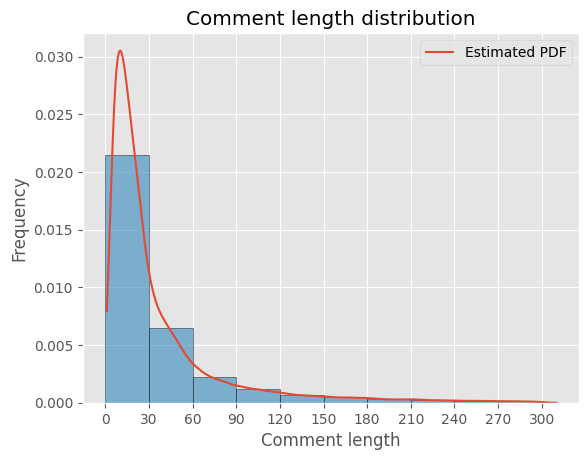

Performing language classification over the given dataset:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 726119/726119 [17:51<00:00, 677.83it/s]

Done with language classification.
Creating the language distribution plot:


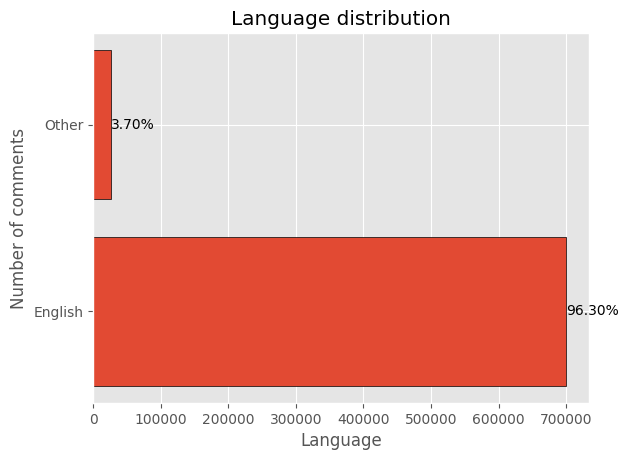

In [43]:
def identify_language(sentence : str):
    return langcodes.Language.get((langid.classify(sentence))[0]).display_name()

def sentence_word_length(sentence : str):
    return len(sentence.split(" "))

def word_length_distribution(dataset_path : str):
    df = pd.read_csv(dataset_path)
    print("Calculating sentence length over the given dataset.")
    df["WordLength"] = df["Content"].progress_apply(sentence_word_length)
    print("Done with sentence length calculation.")

    value_counts = df["WordLength"].value_counts().to_dict()
    lengths = []

    for key, value in value_counts.items():
        lengths = lengths + [key] * value

    print("Creating the sentence length distribution plot:")
    kde = gaussian_kde(lengths)
    fig, ax = plt.subplots()

    ax.set_xlabel("Comment length")
    ax.set_ylabel("Frequency")
    ax.set_title("Comment length distribution")

    x = np.linspace(min(lengths), max(lengths), 1000)
    bin_values = np.array(list(range(0, 301, 30)))
    ax.plot(x, kde(x), label = "Estimated PDF")
    ax.hist(lengths, alpha = 0.6, edgecolor = "black", density = True, bins = bin_values)
    ax.legend()
    ax.set_xticks(bin_values)
    plt.show()
    # fig_file = os.path.join(figures_dir, "sentence_length_distribution.png")
    # fig.savefig(fig_file, bbox_inches = "tight")
    # print("Sentence length distribution plot created and saved.")

def transform_language_counts(value_counts, threshold : float = 0.1):
    total = sum(v for v in value_counts.values())
    new_dict = {}

    for key, value in value_counts.items():
        if value >= int(total * threshold):
            new_dict[key] = value
        
        else:
            new_dict["Other"] = new_dict.get("Other", 0) + value
    
    return new_dict, total

def language_distribution(dataset_path : str, threshold : float = 0.1):
    df = pd.read_csv(dataset_path)
    print("Performing language classification over the given dataset:")
    df["Language"] = df["Content"].progress_apply(identify_language)
    print("Done with language classification.")
    
    value_counts = df["Language"].value_counts().to_dict()
    value_counts, total = transform_language_counts(value_counts, threshold)

    print("Creating the language distribution plot:")
    
    fig, ax = plt.subplots()
    bars = ax.barh(list(value_counts.keys()), value_counts.values(), edgecolor = "black")
    ax.set_xlabel("Language")
    ax.set_ylabel("Number of comments")
    ax.set_title("Language distribution")

    for bar in bars:
        width = bar.get_width()
        y_position = bar.get_y() + bar.get_height() / 2  # Positioning text vertically centered on the bar

        # Add number on top of the bar
        ax.text(width, y_position, f"{(width / total) * 100:.2f}%", ha = "left", va = "center", fontsize = 10, color = "black")

        # Draw a line from the label to the bar
        ax.plot([width, width + 0.2], [y_position, y_position], color = "black", linewidth = 0.7)
    plt.show()
    # plt.savefig(os.path.join(figures_dir, "language_distribution.png"), bbox_inches = "tight")

word_length_distribution(DATA_PATH)
language_distribution(DATA_PATH)

# Fine-tuning an encoder model
For encoder models I've mostly experimented with RoBERTa encoders (https://huggingface.co/FacebookAI/roberta-base), but feel free to try different models. If you cannot afford long training times, I suggest taking a look at distilled variants, for RoBERTa - https://huggingface.co/distilbert/distilroberta-base. We will not fine-tune the full model, instead just a LoRA, with a configurable rank parameter.

In [5]:
MODEL_URL = "roberta-base"
CLASSIFIER_DROPOUT = 0.1
LORA_DROPOUT = 0.1
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 5e-3
BATCH_SIZE = 8

GRAD_ACCUM = 4
LORA_RANK = 32
LORA_ALPHA = LORA_RANK
# Running on Kaggle
# CHECKPOINT_DIR = os.path.join("/", "kaggle", "working", "encoder_checkpoints", "roberta_lora")
# Running locally
CHECKPOINT_DIR = os.path.join("encoder_checkpoints", "roberta_base_alllora_r32_bs32_rslora")
FROM_CHECKPOINT = True # Set to True if you want to continue training from a checkpoint, otherwise set to None. False maybe works even?
TRAIN_EPOCHS = 8
WARMUP_RATIO = 0.1
DATA_RATIO = 1 # Load only portion of the dataset for debugging, should be set to 1 once debugging is done.
DISABLE_TQDM = False # I've had issues with TQDM rendering inside a notebook

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## HuggingFace Dataset API integration
We will use HuggingFace Dataset API to implement our dataset. Additionally, we will use the F1 metric to evaluate trained models. Even though in my opinion ROC-AUC metric provides is a more robust metric for comparing classification models because it incorporates different confidence thresholds, encoder-decoder models' output probability distributions cannot be easily converted to classwise probability distribution, so we can only rely on macro-average F1 for them.

One possible optimization is to pre-tokenize the entire dataset, since tokenization is deterministic, and does not need to be repeated for every batch - we use Dataset.map function for that. Alternatively, you can save the result of pre-tokenization to a file and load sequences from the given file by using cache_file_name option, which is commented out currently.

In [6]:
def tokenize_function(batch, tokenizer):
    # model maximum length is encoded in the pre-trained tokenizer.
    inputs = tokenizer(batch["Content"], truncation = True, padding = False, return_attention_mask = False)
    inputs["labels"] = batch["Label"]
    return inputs

tokenizer = AutoTokenizer.from_pretrained(MODEL_URL, legacy = False)
# https://huggingface.co/docs/datasets/v3.5.0/en/package_reference/main_classes#datasets.Dataset.from_pandas
# https://huggingface.co/docs/datasets/v3.5.0/en/package_reference/main_classes#datasets.Dataset.map
train_dataset = Dataset.from_pandas(df_train[:int(len(df_train) * DATA_RATIO)])
train_dataset = train_dataset.map(partial(tokenize_function, tokenizer = tokenizer), 
                                  batched = True, 
                                  remove_columns = train_dataset.column_names,
                                  desc = "Tokenizing the train dataset.",
                                  keep_in_memory = True,
                                  # cache_file_name = "./train.cache",
                                  # load_from_cache_file = True
                                 )

test_dataset = Dataset.from_pandas(df_test[:int(len(df_test) * DATA_RATIO)])
test_dataset = test_dataset.map(partial(tokenize_function, tokenizer = tokenizer), 
                                  batched = True, 
                                  remove_columns = test_dataset.column_names,
                                  desc = "Tokenizing the test dataset.",
                                  keep_in_memory = True,
                                  # cache_file_name = "./test.cache",
                                  # load_from_cache_file = True
                                 )

def compute_f1(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis = -1)
    # This is equivalent to macro-averaged F1 since our dataset is well-balanced.
    f1 = f1_score(labels, preds, average = "weighted")

    return {
        "eval_f1": f1
    }

Tokenizing the train dataset.:   0%|          | 0/580895 [00:00<?, ? examples/s]

Tokenizing the test dataset.:   0%|          | 0/145224 [00:00<?, ? examples/s]

## Training

In [ ]:
id2label = {0: "Non-hateful", 1: "Hateful"}
label2id = {"Hateful": 1, "Non-hateful": 0}

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_URL,
    num_labels = 2,
    classifier_dropout = CLASSIFIER_DROPOUT,
    id2label = id2label,
    label2id = label2id,
    token = False
).to(DEVICE)

trainable_model_params = sum(p.numel() for p in model.parameters())

lora_config = LoraConfig(
    r = LORA_RANK,
    lora_dropout = LORA_DROPOUT,
    bias = "none",
    lora_alpha = LORA_ALPHA,
    task_type = "SEQ_CLS",
    target_modules = ["query", "key", "value", "dense"], # By default only key and value linear maps lare lora-ed, this adds more expressivity
    # at the cost of model complexity.
    layers_to_transform = list(range(12)), # Apply loras on every layer of the base model, except the classification head.
    use_rslora = True
)

model = get_peft_model(model, lora_config)
lora_trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of model trainable parameters: {trainable_model_params}")
print(f"Number of LoRA trainable parameters: {lora_trainable_parameters}")
print(f"Comperssion ratio: {trainable_model_params / lora_trainable_parameters:.4f}")

# Only applies within-batch sequence padding, to the length of the longest sequence.
# We did not perform padding in Dataset.map due to redundancy, we are only storing "important" tokens!
collator = DataCollatorWithPadding(tokenizer = tokenizer, padding = "longest")

trainer_args = TrainingArguments(
    output_dir = CHECKPOINT_DIR,
    overwrite_output_dir = True,
    fp16 = False,
    report_to = "none",
    gradient_accumulation_steps = GRAD_ACCUM,
    per_device_train_batch_size = BATCH_SIZE,
    seed = SEED,
    data_seed = SEED,
    learning_rate = LEARNING_RATE,
    weight_decay = WEIGHT_DECAY,
    save_strategy = "epoch",
    eval_strategy = "epoch",
    logging_strategy = "epoch",
    num_train_epochs = TRAIN_EPOCHS,
    save_total_limit = 2,
    load_best_model_at_end = True,
    greater_is_better = True,
    metric_for_best_model = "eval_f1",
    lr_scheduler_type = "cosine",
    warmup_ratio = WARMUP_RATIO,
    disable_tqdm = DISABLE_TQDM,
    ddp_find_unused_parameters = False
)

trainer = Trainer(
    model = model,
    args = trainer_args,
    train_dataset = train_dataset,
    eval_dataset = test_dataset,
    compute_metrics = compute_f1,
    data_collator = collator
)

trainer.train(resume_from_checkpoint = FROM_CHECKPOINT)

## Final inference
I trained a LoRA with $\approx 5M$ trainable parameters, and I published the model to the HuggingFace hub (https://huggingface.co/lukau2357/roberta-lora-hate-speech). If you want to avoid training, you can immediately perform inference. My model achieved $0.91$ macro-averaged $F_1$ on the previously created evaluation set. 

The code cells bellow perform one final evaluation iteration, and based on model predictions and true class labels the cells output the confusion matrix and classification_reprot from sklearn's API. In my opinion this is a solid model, but the results can be improved with more thoughtful hyperparameter optimisation, check out the dedicated section for HPO to see how this can potentially be done.

In [46]:
model = AutoModelForSequenceClassification.from_pretrained("lukau2357/roberta-lora-hate-speech").to(DEVICE)
# RoBERTa is the base model, and the same tokenizer is retained.
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
collator = DataCollatorWithPadding(tokenizer = tokenizer, padding = "longest")

eval_preds, eval_true = [], []
with torch.no_grad():
    for i in tqdm_notebook(range(0, len(test_dataset), 16), desc = "Final model evaluation"):
        current_batch = test_dataset[i : i + 16]
        current_batch = collator(current_batch)
        eval_true.extend(current_batch["labels"].tolist())
        pred = model(**(current_batch.to(DEVICE)))
        pred = torch.argmax(pred["logits"], dim = -1)
        eval_preds.extend(pred.tolist())

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Final model evaluation:   0%|          | 0/9077 [00:00<?, ?it/s]

In [47]:
print(classification_report(eval_true, eval_preds, target_names = ["Non-hateful", "Hateful"]))

              precision    recall  f1-score   support

 Non-hateful       0.89      0.95      0.91     72319
     Hateful       0.94      0.88      0.91     72905

    accuracy                           0.91    145224
   macro avg       0.91      0.91      0.91    145224
weighted avg       0.91      0.91      0.91    145224



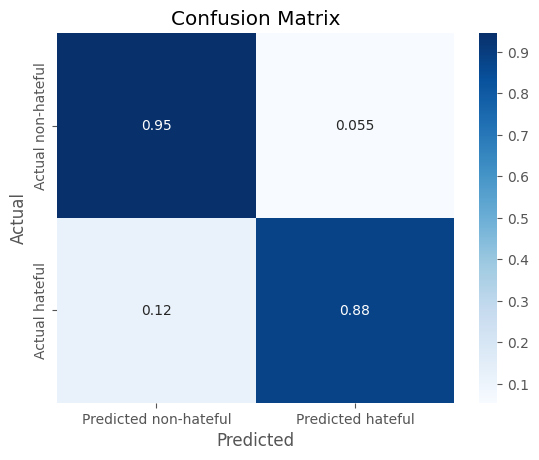

In [49]:
cm = confusion_matrix(eval_true, eval_preds, normalize = "true")
sns.heatmap(cm, annot  =True, cmap='Blues', 
            xticklabels = ['Predicted non-hateful', 'Predicted hateful'], 
            yticklabels = ['Actual non-hateful', 'Actual hateful'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
# plt.savefig("./figures/roberta_confusion_matrix.png")

If you want to manually classify sentences, you can use the code below.

In [41]:
id2label = {0: "Non-hateful", 1: "Hateful"}

with torch.no_grad():
    sentences = ["Thank you very much.", "I hate you!"]
    # Model was trained with lower-cased data, so the forwarded sentences should be lowercased as well.
    sentences_lower = [s.lower() for s in sentences]
    enc = tokenizer(sentences, padding = True, truncation = True, return_tensors = "pt").to(DEVICE)
    res = model(**enc)

    logits = res.logits.cpu()
    probs = torch.nn.functional.softmax(logits, dim = -1)
    preds = torch.argmax(probs, dim = -1)
    counter = 0

    for pred, sentence in zip(preds, sentences):
        print(f"{sentence} Prediction: {id2label[int(pred.item())]} Probabilities: {probs[counter][0]:.4f} {probs[counter][1]:.4f}")
        counter += 1

Thank you very much. Prediction: Non-hateful Probabilities: 0.9703 0.0297
I hate you! Prediction: Hateful Probabilities: 0.3308 0.6692


# Fine tuning an encoder-decoder model
Now we will try to utilize a full encoder-decoder architecture to see if we can improve previous results. One of the most popular encoder-decoder models is **T5 - Text to Text Transfer Transformer** (https://arxiv.org/pdf/1910.10683). On a high level, it transforms all NLP tasks into text2text problems, and then solves them using an encoder/decoder architecture. A high level overview of this paradigm can be seen of the figure below:

![no figure](https://miro.medium.com/v2/resize:fit:791/1*QOVXAn0bx8HKGrBIXAgydw.png)

We will take a pretrained T5 model, and fine-tune it for text classification. For this setting, our encoder will take the sentence in question, and the decoder will be fine-tuned to autoregressively predict the correct class. Class labels that we choose are also hyperparameters, but I do not think they can effect results that much if the model is trained for sufficiently long, provided that they are semantically consistent with actual labels of course.

In [4]:
MODEL_URL = "google/flan-t5-base"
LORA_DROPOUT = 0.1
LORA_ALPHA = 18
LEARNING_RATE = 3e-4 # Authors of FLAN T5 use higher learning rate compared to that of RoBERTa, we will adhere to that.
WEIGHT_DECAY = 1e-3
BATCH_SIZE = 8
GRAD_ACCUM = 2
LORA_RANK = 18
# Running on Kaggle
# CHECKPOINT_DIR = os.path.join("/", "kaggle", "working", "encoder_decoder_checkpoints", "flan_t5_small_test")
# Running locally
CHECKPOINT_DIR = os.path.join("encoder_decoder_checkpoints", "flan_t5_base_r18_e8")
FROM_CHECKPOINT = True # Set to True if you want to continue training from a checkpoint, otherwise set to None. False maybe works even?
TRAIN_EPOCHS = 8
WARMUP_RATIO = 0.1
DATA_RATIO = 1 # Load only portion of the dataset for debugging, should be set to 1 once debugging is done.
DISABLE_TQDM = False # I've had issues with TQDM rendering inside a notebook
HATE_LABEL = "Hateful"
NON_HATE_LABEL = "Non-hateful"

LABEL2TEXT = {
    0: NON_HATE_LABEL,
    1: HATE_LABEL
}

TEXT2LABEL = {
    v: k for k, v in LABEL2TEXT.items()
}

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PREFIX = f"Classify this sentence as {HATE_LABEL} or {NON_HATE_LABEL} speech:"

## Encoder-decoder dataset class
Pre-processing for encoder-decoder models is more complex - target sequences need to be shifted accordingly. Instead of using PyTorch Dataset, we will use HuggingFace Dataset API, along with DataCollatorForSeq2Seq. With these 2 classes, we will delegate the entire tokenization procedure to HuggingFace. Additionally, HuggingFace Dataset will allow us to easily pre-tokenize the entire dataset, which was an issue with previous encoder approach.

In [5]:
def tokenize_function(batch, tokenizer, prefix = ""):
    # model maximum length is encoded in the pre-trained tokenizer.
    content = [f"{prefix} {x}".strip() for x in batch["Content"]]
    inputs = tokenizer(content, truncation = True, padding = False)
    targets = tokenizer(text_target = [LABEL2TEXT[int(x)] for x in batch["Label"]], truncation = True, padding = False)
    inputs["labels"] = targets["input_ids"]
    return inputs
    
tokenizer = AutoTokenizer.from_pretrained(MODEL_URL, legacy = False)
# https://huggingface.co/docs/datasets/v3.5.0/en/package_reference/main_classes#datasets.Dataset.from_pandas
# https://huggingface.co/docs/datasets/v3.5.0/en/package_reference/main_classes#datasets.Dataset.map
train_dataset = Dataset.from_pandas(df_train[:int(len(df_train) * DATA_RATIO)])
train_dataset = train_dataset.map(partial(tokenize_function, tokenizer = tokenizer, prefix = PREFIX), 
                                  batched = True, 
                                  remove_columns = train_dataset.column_names,
                                  desc = "Tokenizing the train dataset.",
                                  keep_in_memory = True
                                  # cache_file_name = os.path.join("/", "kaggle", "working", "train_seq2seq.cache"),
                                  # load_from_cache_file = True
                                 )

test_dataset = Dataset.from_pandas(df_test[:int(len(df_test) * DATA_RATIO)])
test_dataset = test_dataset.map(partial(tokenize_function, tokenizer = tokenizer, prefix = PREFIX), 
                                  batched = True, 
                                  remove_columns = test_dataset.column_names,
                                  desc = "Tokenizing the test dataset.",
                                  keep_in_memory = True
                                  # cache_file_name = os.path.join("/", "kaggle", "working", "test_seq2seq.cache"),
                                  # load_from_cache_file = True
                                )

target_encodings = tokenizer(text_target = [v for v in LABEL2TEXT.values()], padding = True, return_tensors = "pt")
MAX_TARGET_LEN = target_encodings["input_ids"].shape[1]

PAD_ID = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)

def compute_f1_seq2seq(pred, tokenizer):
    predictions = pred.predictions
    labels = pred.label_ids
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens = True)
    # Labels are -100 for pad tokens, so replace them with actual pad id.
    # https://huggingface.co/docs/transformers/en/model_doc/t5?usage=AutoModel#transformers.T5ForConditionalGeneration.forward.labels
    labels[labels == -100] = PAD_ID
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens = True)

    decoded_labels = [TEXT2LABEL[item] for item in decoded_labels]
    decoded_preds = [TEXT2LABEL.get(item.strip(), -1) for item in decoded_preds]

    # Class -1 captures the case when model output does not match to any of the classes, we create a new class for that instance.
    # Since decoded_preds != -1 always, the number of instances having class -1 is always 0, so we explicitly set zero_divison = 0
    # so that our final result is not affected by this.
    f1 = f1_score(decoded_preds, decoded_labels, labels = [0, 1, -1], average = "weighted", zero_division = 0)
    
    return {
        "eval_f1": f1
    }

Tokenizing the train dataset.:   0%|          | 0/580895 [00:00<?, ? examples/s]

Tokenizing the test dataset.:   0%|          | 0/145224 [00:00<?, ? examples/s]

## Optional base model evaluation
Optionally, you can evaluate the performance of a baseline T5 model. A model like FLAN-T5 which we will be using which was fine-tuned already should give reasonable results - I would expect above 0.6 F1. We will perform another iteration of fine-tuning over our dataset to further push the performance.

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_URL).to(DEVICE)
predictions, ground_truth = [], []

with torch.no_grad():
    print(f"Baseline model evaluation: {MODEL_URL}")
    batch_size = 128
    
    for i in tqdm_notebook(range(0, len(test_dataset), batch_size)):
        batch = test_dataset[i : i + batch_size]
        # Manual padding because of dataset construction required.
        batch = tokenizer.pad(batch, padding = "longest")
        input_ids = torch.tensor(batch["input_ids"], device = DEVICE)
        labels = tokenizer.batch_decode(batch["labels"], skip_special_tokens = True)
        
        output = model.generate(inputs = input_ids, max_new_tokens = MAX_TARGET_LEN)
        output = tokenizer.batch_decode(output, skip_special_tokens = True)
        output = [item.strip() for item in output]

        ground_truth += [TEXT2LABEL[item] for item in labels]
        predictions += [TEXT2LABEL.get(item, -1) for item in output]

# If the model is well-behaved, nothing will be generated outside Hateful and Non-hateful,  
cls_rprt = classification_report(predictions, ground_truth, labels = [0, 1, -1], zero_division = 0)
print(f"Baseline classification report:")
print(cls_rprt)
baseline_f1 = f1_score(predictions, ground_truth, labels = [0, 1], average = "weighted", zero_division = 0)
print(f"Baseline F1:")
print(baseline_f1)

## Training an encoder-decoder model

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_URL).to(DEVICE)
# generate calls will default to greedy decoding. The decoding algorithm can be viewed as a hyperparameter also!
# https://huggingface.co/docs/transformers/v4.51.0/en/main_classes/text_generation#transformers.GenerationConfig
print(f"Model generation config: {model.generation_config}")

lora_config = LoraConfig(
    r = LORA_RANK,
    lora_dropout = LORA_DROPOUT,
    bias = "none",
    lora_alpha = LORA_ALPHA,
    task_type = "SEQ_2_SEQ_LM",
    # at the cost of model complexity.
    layers_to_transform = list(range(12)), # Apply loras on every layer of the base model, except the classification head.
    use_rslora = True
)

trainable_model_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model = get_peft_model(model, lora_config)

# Autoregressive generation is significantlly slower than a simple forward pass through the model
# which explains why training is slower as well on a T5 model.
#import time
#x = train_dataset[:16]
#x["input_ids"] = torch.tensor(x["input_ids"]).to(DEVICE)
#x["attention_mask"] = torch.tensor(x["attention_mask"]).to(DEVICE)
#x["labels"] = torch.tensor(x["labels"]).to(DEVICE)
#start = time.time()
#y = model.generate(**x, max_length = MAX_TARGET_LEN)
# y = model(**x)
#end = time.time()
#print(f"Generation time: {end - start}:.4f seconds.")
#print(y)
#return

lora_trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

# 124647170 - Number of RoBERTa-base parameters
# 247577856 - Number of T5 base parameters. Roughly 2 times higher than RoBERTa, which is expected.
print(f"Number of model trainable parameters: {trainable_model_params}")
print(f"Number of LoRA trainable parameters: {lora_trainable_parameters}")
print(f"Compression ratio: {trainable_model_params / lora_trainable_parameters:.4f}")

collator = DataCollatorForSeq2Seq(tokenizer = tokenizer, model = model, padding = "longest")

# Control predict_with_generate behaviour:
# https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.Seq2SeqTrainingArguments.predict_with_generate
# https://huggingface.co/docs/transformers/v4.51.0/en/main_classes/text_generation#transformers.GenerationConfig
# https://huggingface.co/docs/transformers/en/main_classes/text_generation#transformers.GenerationMixin.generate
# Defaults to greedy decoding, this can also be seen as a training hyperparameter!
training_args = Seq2SeqTrainingArguments(
    output_dir = CHECKPOINT_DIR,
    overwrite_output_dir = True,
    fp16 = False,
    report_to = "none",
    gradient_accumulation_steps = GRAD_ACCUM,
    per_device_train_batch_size = BATCH_SIZE,
    seed = SEED,
    data_seed = SEED,
    learning_rate = LEARNING_RATE,
    weight_decay = WEIGHT_DECAY,
    save_strategy = "epoch",
    eval_strategy = "epoch",
    logging_strategy = "epoch",
    num_train_epochs = TRAIN_EPOCHS,
    save_total_limit = 2,
    load_best_model_at_end = True,
    greater_is_better = True,
    metric_for_best_model = "eval_f1",
    lr_scheduler_type = "cosine",
    warmup_ratio = WARMUP_RATIO,
    disable_tqdm = DISABLE_TQDM,
    ddp_find_unused_parameters = False,
    predict_with_generate = True,
    generation_config = MODEL_URL,
    generation_max_length = MAX_TARGET_LEN # Attempt to optimize generation a little bit...
)

# Can't solve Trainer.tokenizer is deprecated warning...
# https://github.com/hiyouga/LLaMA-Factory/issues/6130
trainer = Seq2SeqTrainer(
    model = model,
    args = training_args,
    data_collator = collator,
    train_dataset = train_dataset,
    eval_dataset = test_dataset,
    compute_metrics = partial(compute_f1_seq2seq, tokenizer = tokenizer)
)
trainer.train(resume_from_checkpoint = FROM_CHECKPOINT)

FLAN-T5 ended up performing worse than RoBERTa, so I did not include additional code for final inference based on this model.

# Optional: Hyperparameter optimization
With this setup, RoBERTa achieves better F1 than FLAN-T5. Although results for FLAN-T5 could probably be improved by additional hyperparameter optimzation, training time for FLAN-T5 is significantly longer than training time for RoBERTa, due to the former being a full encoder-decoder architecture, we require autoregressive decoding during evaluation.

We've decided to perform a more extensive hyperparameter search on RoBERTa, using **optuna**. The main bottleneck for this particular problem is the size of the dataset - $\approx 500 \times 10^3$ sentences in the training set, so we can expect relatively long training times even with lower LoRA rank values. Therefore, we perform hyperparameter optimization only on the portion of the original dataset. In particular, we take a 30% stratified sample of the original dataset, and from there construct train/validation datasets with the train dataset having 80% of the previously sampled rows - this amounts to training on roughly a quarter of the original dataset. These values are configurable in the cell below, as well as the maximum and minimum learning rate and weight decay values during HPO.

In [4]:
# Minimum and maximum learning rate
LR_MIN = 1e-6
LR_MAX = 1

# Minimum and maximum weight decay
WD_MIN = 1e-5
WD_MAX = 1e-1

HPO_TRAIN_EPOCHS = 4
HPO_DATA_RATIO = 0.25
HPO_TRAIN_FRAC = 0.8
WARMUP_RATIO = 0.1
# Number of HPO rounds to perform. Generally greater is better.
HPO_TRIALS = 10
# Number of epochs to perform during single HPO instance
HPO_EPOCHS = 8

MODEL_URL = "roberta-base"
CLASSIFIER_DROPOUT = 0.1
LORA_DROPOUT = 0.1

# Could also optimize over batch size, decided to keep it fixed to 32.
BATCH_SIZE = 8
GRAD_ACCUM = 4

# Kept LoRA rank fixed to 32, generally in big data regime bigger transformer models will outperform smaller ones.
# Potentially calibrate this parameter as well.
LORA_RANK = 32
LORA_ALPHA = LORA_RANK

DISABLE_TQDM = False # I've had issues with TQDM rendering inside a notebook
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

id2label = {0: "Non-hateful", 1: "Hateful"}
label2id = {"Hateful": 1, "Non-hateful": 0}

In [5]:
hpo_dataset, _ = tt_split(DATA_PATH, HPO_DATA_RATIO, DATA_DIR, SEED, verbose = False)
hpo_train_df, hpo_test_df, _, _ = train_test_split(hpo_dataset, hpo_dataset["Label"], 
                                                  train_size = HPO_TRAIN_FRAC, 
                                                  random_state = SEED, 
                                                  stratify = hpo_dataset["Label"])

# Verify that HPO train and test datasets preserve original class distribution.
print(hpo_train_df["Label"].value_counts())
print(hpo_test_df["Label"].value_counts())

Label
1    145
0    145
Name: count, dtype: int64
Label
1    37
0    36
Name: count, dtype: int64


We use the same dataset structure as with initial RoBERTa model. Code is exactly the same, except for using different data frames for dataset construction. Code repetition could have been avoided with a more thoughtful code parameterisation.

In [ ]:
def tokenize_function(batch, tokenizer):
    # model maximum length is encoded in the pre-trained tokenizer.
    inputs = tokenizer(batch["Content"], truncation = True, padding = False, return_attention_mask = False)
    inputs["labels"] = batch["Label"]
    return inputs

tokenizer = AutoTokenizer.from_pretrained(MODEL_URL, legacy = False)
# https://huggingface.co/docs/datasets/v3.5.0/en/package_reference/main_classes#datasets.Dataset.from_pandas
# https://huggingface.co/docs/datasets/v3.5.0/en/package_reference/main_classes#datasets.Dataset.map
train_dataset = Dataset.from_pandas(hpo_train_df)
train_dataset = train_dataset.map(partial(tokenize_function, tokenizer = tokenizer), 
                                  batched = True, 
                                  remove_columns = train_dataset.column_names,
                                  desc = "Tokenizing the train dataset.",
                                  keep_in_memory = True,
                                  # cache_file_name = "./train.cache",
                                  # load_from_cache_file = True
                                 )

test_dataset = Dataset.from_pandas(hpo_test_df)
test_dataset = test_dataset.map(partial(tokenize_function, tokenizer = tokenizer), 
                                  batched = True, 
                                  remove_columns = test_dataset.column_names,
                                  desc = "Tokenizing the test dataset.",
                                  keep_in_memory = True,
                                  # cache_file_name = "./test.cache",
                                  # load_from_cache_file = True
                                 )

def compute_f1(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis = -1)
    # This is equivalent to macro-averaged F1 since our dataset is well-balanced.
    f1 = f1_score(labels, preds, average = "weighted")

    return {
        "eval_f1": f1
    }

In [ ]:
class EvalCallback(TrainerCallback):
    def __init__(self, trial):
        self.trial = trial
        
    def on_evaluate(self, args, state, control, **kwargs):
        return
        # Pruning seems to be too strict. Uncomment to enable prunning
        # eval_f1 = kwargs["metrics"]["eval_f1"]
        # self.trial.report(eval_f1, step = state.epoch)
        # if self.trial.should_prune():
        #    raise optuna.TrialPruned()

def model_init():
    model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_URL, 
    num_labels = 2,
    classifier_dropout = CLASSIFIER_DROPOUT,
    id2label = id2label,
    label2id = label2id).to(DEVICE)

    trainable_model_params = sum(p.numel() for p in model.parameters())
    
    lora_config = LoraConfig(
        r = LORA_RANK,
        lora_dropout = LORA_DROPOUT,
        bias = "none",
        lora_alpha = LORA_ALPHA,
        task_type = "SEQ_CLS",
        target_modules = ["query", "key", "value", "dense"], # By default only key and value linear maps lare lora-ed, this adds more expressivity
        # at the cost of model complexity.
        layers_to_transform = list(range(12)), # Apply loras on every layer of the base model, except the classification head.
        use_rslora = True
    )
    
    model = get_peft_model(model, lora_config)
    lora_trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Number of model trainable parameters: {trainable_model_params}")
    print(f"Number of LoRA trainable parameters: {lora_trainable_parameters}")
    print(f"Comperssion ratio: {trainable_model_params / lora_trainable_parameters:.4f}")
    
    return model

def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', LR_MIN, LR_MAX, log = True)
    weight_decay = trial.suggest_float("weight_decay", WD_MIN, WD_MAX, log = True)
    
    trainer_args = TrainingArguments(
        output_dir = None,
        save_strategy = "no",
        overwrite_output_dir = True,
        fp16 = False,
        report_to = "none",
        gradient_accumulation_steps = GRAD_ACCUM,
        seed = SEED,
        data_seed = SEED,
        # No eval strategy since it is performed manually
        eval_strategy = "epoch",
        logging_strategy = "epoch",
        per_device_train_batch_size = BATCH_SIZE,
        learning_rate = learning_rate,
        weight_decay = weight_decay,
        num_train_epochs = HPO_EPOCHS,
        lr_scheduler_type = "cosine",
        metric_for_best_model = "eval_f1",
        warmup_ratio = WARMUP_RATIO,
        disable_tqdm = DISABLE_TQDM,
        ddp_find_unused_parameters = False
    )

    collator = DataCollatorWithPadding(tokenizer = tokenizer, padding = "longest")
    model = model_init()
    
    trainer = Trainer(
        model = model,
        data_collator = collator,
        train_dataset = train_dataset,
        eval_dataset = test_dataset,
        compute_metrics = compute_f1,
        args = trainer_args
    )
    
    trainer.add_callback(EvalCallback(trial))
    trainer.train()
    
    # Extract validation loss from last evaluate and return that as HPO result for the current trial
    parsed_history = parse_log_history(trainer.state.log_history)
    res = float("-inf")

    for item in parsed_history[1]:
        res = max(res, item.get("F1", 0))
    
    return res

# Checkpointing for Optuna HPO since it does take a while to complete.
study_name = "roberta-hpo"
storage_name = f"sqlite:///{os.path.join(os.getcwd(), study_name + '.db')}"
study = optuna.create_study(storage = storage_name, study_name = study_name, direction = "maximize", load_if_exists = True)
study.optimize(objective, n_trials = HPO_TRIALS)

with open(os.path.join(os.getcwd(), study_name + '_best_params.json'), "w+") as f:
    res = {
        "trial_number": study.best_trial.number,
        "best_value": study.best_value,
        "params": study.best_params
    }
    json.dump(res, f)